# Fully Integrated Ordinary Neural Arithmetic (FIONA)
FIONA is a Restructure algorithm* for the most common Neural Networks, usually referred to as Dense, Fully Connected or Tabular. The output is one or more linear models that each perfectly explain the behaviour of the Neural Network within a defined area.

Two new concepts are introduced as part of FIONA:

**Identity Scoring** is a method of tracking how each input is related to the weights of each layer. By following the relationships through the entire model Identity Scoring allows the final layer to be decoded into a linear model. An interactive [Google Sheets workbook](https://colab.research.google.com/drive/1zrlui_5SO2aW5XSUvzYFPm3gb9s2vSSc#scrollTo=af5fkTbOHENl&line=6&uniqifier=1) is available to explore this concept.

**FIONA Regions** is a method of tracking the boundaries of each model created by Identity Scoring. The application of some types of activation function, like Rectified Linear Unit (ReLU), creates clean breaks in the behaviour of the Neural Networks which can be interpreted as entirely separate linear models.

Wagtail Labs is actively developing FIONA by extending the range of supported languages, frameworks, and layers, as well as improving user experience through code performance and by creating new visualisation tools. To find out more visit https://wagtaillabs.com.

\* An introduction to the RAY framework (Restructure, Assess, Yank) can be found here: https://wagtaillabs.com/2020/10/27/introducing-ray/

# Setup

Tested on
- python 3.6.9 (default, Jul 17 2020, 12:50:27) \n[GCC 8.4.0]
- fastai 1.0.61
- pandas 1.1.3
- numpy 1.18.5
- sklearn 0.22.2.post1
- matplotlib 3.2.2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fastai.tabular import *
import copy
from sklearn.metrics.pairwise import euclidean_distances
from itertools import compress

#libs for 3d plots
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

Set the seed to guarantee consistent results for everyone

In [2]:
seed = 1

# python RNG
import random
random.seed(seed)

# pytorch RNGs
import torch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
import numpy as np
np.random.seed(seed)

def random_seed(seed_value, use_cuda):                  # gleaned from multiple forum posts
    np.random.seed(seed_value)                          # cpu vars
    torch.manual_seed(seed_value)                       # cpu  vars
    random.seed(seed_value)                             # Python
    if use_cuda: torch.cuda.manual_seed_all(seed_value) # gpu 

random_seed(42,True)

Define a couple of helper functions to pull the input and output for each layer of the function. Helpful for debugging and testing.

In [3]:
class SaveFeatures():
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()
        
class SaveInput():
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.inp = input
    def remove(self): self.hook.remove()

def get_inp(x, m, ml):
    sos = [SaveInput(o) for o in [ml]]  #define the hooks in the model
    py = learn.predict(x)
    for o in sos: o.remove()            #remove the hooks from the model
    inp = to_np(sos[0].inp[0])          #pull the features out of the last hook 
    return inp

def get_out(x, m, ml):
    sfs = [SaveFeatures(o) for o in [ml]]  #define the hooks in the model
    py = learn.predict(x)
    for o in sfs: o.remove()               #remove the hooks from the model
    feat = to_np(sfs[0].features[0])       #pull the features out of the last hook 
    return feat

Download data from the Australian Energy Market Operator. Forecasting electricity demand is a non-stationary (new connections, energy efficiency, etc) problem with multiple cycles (hour of day, day of week, month of year, economic cycles, etc), sensitivities (temperature, public holidays, etc), and randomness (unplanned outages, etc). This has proven challenging for most modelling techniques.

In [4]:
%%time
df = pd.read_csv('http://data.wa.aemo.com.au/datafiles/load-summary/load-summary-2010.csv', parse_dates=['Trading Date','Trading Interval'])
for i in range(2011, 2020):
  df=df.append(pd.read_csv('http://data.wa.aemo.com.au/datafiles/load-summary/load-summary-'+str(i)+'.csv', 
                           parse_dates=['Trading Date','Trading Interval']))
df=df[['Trading Interval', 'Metered Generation (Total; MWh)']].dropna()

df.insert(len(df.columns), 'hour', df['Trading Interval'].dt.hour + df['Trading Interval'].dt.minute/60)
df.insert(len(df.columns), 'weekday', df['Trading Interval'].dt.weekday)
df.insert(len(df.columns), 'month', df['Trading Interval'].dt.month)
df.insert(len(df.columns), 'year', df['Trading Interval'].dt.year)

max_temp = pd.read_csv('https://drive.google.com/uc?authuser=0&id=1CHwEwl6A4uqRq_2Q6rtcoICqEMehYR1X&export=download')
min_temp = pd.read_csv('https://drive.google.com/uc?authuser=0&id=1HJV8HtzRlTG_Tn12gUEPemqNt-4E-QWo&export=download')
temp = max_temp.merge(min_temp, left_on=['Year','Month','Day'], right_on=['Year','Month','Day']).dropna()
temp = temp[['Year','Month','Day','Maximum temperature (Degree C)', 'Minimum temperature (Degree C)']]
temp['max_lag1'] = temp['Maximum temperature (Degree C)'].shift(periods=1)
temp['min_lag1'] = temp['Minimum temperature (Degree C)'].shift(periods=1)
temp['max_lag2'] = temp['Maximum temperature (Degree C)'].shift(periods=2)
temp['min_lag2'] = temp['Minimum temperature (Degree C)'].shift(periods=2)
temp['max_lead1'] = temp['Maximum temperature (Degree C)'].shift(periods=-1)
temp['min_lead1'] = temp['Minimum temperature (Degree C)'].shift(periods=-1)
df.insert(len(df.columns), 'day', df['Trading Interval'].dt.day)
df = df.merge(temp, left_on=['year','month','day'], right_on=['Year','Month','Day']).drop(['day', 'Year', 'Month', 'Day'], axis=1)

solar_output = pd.read_csv('https://drive.google.com/uc?authuser=0&id=1LKKPydF9Owcof9z2hSWjNQjQiy-tCLYa&export=download')
solar_output = solar_output[['Year','Month','Day','Daily global solar exposure (MJ/m*m)']]
df.insert(len(df.columns), 'day', df['Trading Interval'].dt.day)
df = df.merge(solar_output, left_on=['year','month','day'], right_on=['Year','Month','Day']).drop(['day', 'Year', 'Month', 'Day'], axis=1)

df.columns = df.columns.str.replace(' ', '')
df.columns = df.columns.str.replace(')', '')
df.columns = df.columns.str.replace('(', '')
df.columns = df.columns.str.replace('/', '')
df.columns = df.columns.str.replace('*', '')
df.columns = df.columns.str.replace(';', '')

CPU times: user 1.03 s, sys: 215 ms, total: 1.24 s
Wall time: 1min 11s


Prep the data for input into fast.ai. We've limited the model to three continuous variables for plotting purposes.

In [5]:
procs = [FillMissing, Categorify, Normalize]
cat_names = ['hour', 'weekday', 'month']
cont_names = ['year','MaximumtemperatureDegreeC','MinimumtemperatureDegreeC']#,'max_lag1','min_lag1','max_lag2','min_lag2','max_lead1','min_lead1','DailyglobalsolarexposureMJmm']
dep_var = 'MeteredGenerationTotalMWh'

data = (TabularList.from_df(df, cont_names=cont_names, cat_names=cat_names, procs=procs)
        .split_by_idx(valid_idx=range(int(len(df)-365*48),len(df)))
        .label_from_df(cols=dep_var)
        .add_test(TabularList.from_df(df.head(len(df)-365*48), cat_names=cat_names, cont_names=cont_names, procs=procs))
        .databunch())
print(data.train_ds.cont_names)
print(data.train_ds.cat_names)

['year', 'MaximumtemperatureDegreeC', 'MinimumtemperatureDegreeC']
['hour', 'weekday', 'month']


Now train a very simple model.

In [6]:
learn = tabular_learner(data, layers=[10])
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-2))

epoch,train_loss,valid_loss,time
0,6011.406250,10114.166016,00:18
1,5282.827148,7097.572266,00:18
2,4976.260742,6667.508789,00:18


And plot out performance on the training and validation sets.

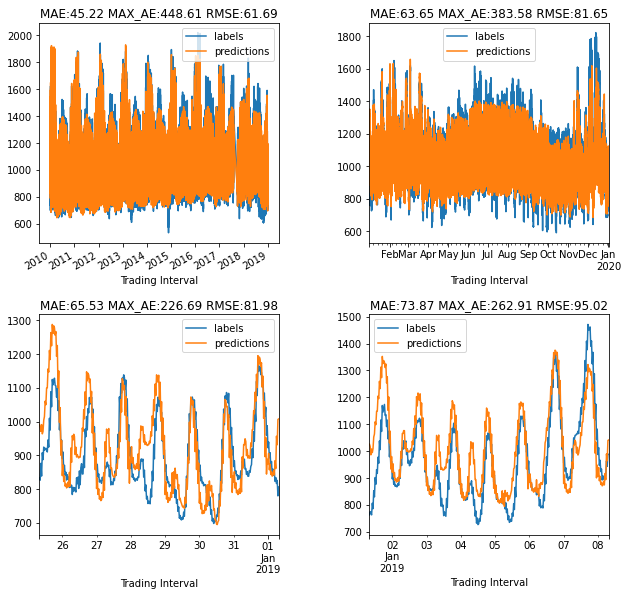

In [7]:
def check_predictions(learn, df):
  fig,axes  = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
  fig.tight_layout(pad=6.0)
  t_labels = pd.DataFrame({'labels': df.head(len(df)-365*48)['MeteredGenerationTotalMWh']})
  t_predictions, _ = learn.get_preds(ds_type=DatasetType.Test)
  t_predictions = pd.DataFrame({'predictions': t_predictions[:,0].tolist()})
  v_labels = pd.DataFrame({'labels': learn.data.valid_ds.y.items.tolist()})
  v_predictions, _ = learn.get_preds(ds_type=DatasetType.Valid)
  v_predictions = pd.DataFrame({'predictions': v_predictions[:,0].tolist()})
  predictions_plot(t_labels, t_predictions, df.head(len(df)-365*48), axes[0,0])
  predictions_plot(v_labels, v_predictions, df.tail(365*48), axes[0,1])
  predictions_plot(t_labels.tail(7*48), t_predictions.tail(7*48), df.head(len(df)-365*48).tail(7*48), axes[1,0])
  predictions_plot(v_labels.head(7*48), v_predictions.head(7*48), df.tail(365*48).head(7*48), axes[1,1])

def predictions_plot(labels, predictions, df, ax):
  errors = abs(predictions['predictions'] - labels['labels'])
  title='MAE:' + str(round(np.mean(errors), 2)) + \
        ' MAX_AE:' + str(round(np.max(abs(errors)), 2)) + \
        ' RMSE:' + str(round(np.sqrt(np.mean(np.square(errors))), 2))
  pd.DataFrame({'labels': labels['labels'], 
                'predictions': predictions['predictions'],
                'Trading Interval': df['TradingInterval'].tolist()}).plot(title=title, ax=ax, x='Trading Interval')
                
check_predictions(learn, df)

# Walkthrough

Let's have a look at fast.ai's standard tabular model.

In [8]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(49, 14)
    (1): Embedding(8, 5)
    (2): Embedding(13, 7)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=10, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=10, out_features=1, bias=True)
  )
)

Let's pick a record at random for testing.

In [9]:
raw_input = df.iloc[172319]
raw_input

TradingInterval                 2020-01-01 07:30:00
MeteredGenerationTotalMWh                   767.148
hour                                            7.5
weekday                                           2
month                                             1
year                                           2020
MaximumtemperatureDegreeC                      31.9
MinimumtemperatureDegreeC                      15.3
max_lag1                                       30.8
min_lag1                                       12.7
max_lag2                                       26.2
min_lag2                                       13.9
max_lead1                                      24.9
min_lead1                                      16.4
DailyglobalsolarexposureMJmm                   31.6
Name: 172319, dtype: object

Let's massage the input into fast.ai itself a little. We'll use *one_item* to translate our selected record into the right format, but we'll set the categorical variables to 1 because that's a bit easier to input into a linear model. We'd also like to use the raw continuous values, but it's not easy to find the normalisation values in fast.ai (happy for anyone to point us in the right direction).

In [10]:
input = data.one_item(raw_input)[0][0][0].detach().numpy()
input[:] = 1
input = np.append(input, data.one_item(raw_input)[0][1][0].detach().numpy())
input = np.expand_dims(input, 1)
input

array([[1.      ],
       [1.      ],
       [1.      ],
       [2.354905],
       [0.989571],
       [0.509144]])

Let's make sure that the continuous variables are the same as what's going into the first layer of the model.

In [11]:
get_inp(df.iloc[172319], learn.model, learn.model.bn_cont)

array([[2.354905, 0.989571, 0.509144]], dtype=float32)

Next we'll define a function to create the edges of the search space. It's important because a Neural Network's behaviour is linked with the intersection of the different channel and all non-parallel lines at some point, which may result in up to *2^#channels* regions. Some of them may occur at values that aren't of interest. (billions of degrees, year 3000, etc), so they can be ignored.

The output is a list of two dataframes where each row defines the start/end endpoint of a line in the boundary, i.e. the first line is from edge0[0] to edge1[0].

For this walkthrough we'll define the area of interest as the extremes of the supplied data. *fiona_Initialise_Edges* recurses through the continuous inputs and expands the shape along the new axis.

In [12]:
def fiona_Initialise_Edges(learn, edges, i):
  training_data = learn.data.train_ds.x.inner_df.append(
                  learn.data.valid_ds.x.inner_df).append(
                  learn.data.test_ds.x.inner_df)                                  #Pull the data from the learner
  col = learn.data.train_ds.cont_names[i]                                         #Pull the continuous variable name we're considering
  min_value = min(training_data[col])                                             #Find the extreme values for that variable
  max_value = max(training_data[col])

  if i == 0:                                                                      #If this is iteration zero
    edges[0][col] = min_value                                                     #Then the boundary is a single line
    edges[1][col] = max_value                                                     #From the min to the max value
  else: 
    min_zero_edges = edges[0].copy()                                              #If we're expanding then copy the boundaries
    max_zero_edges = edges[0].copy()                                              #The Min and Max copies simply add the new values
    min_one_edges = edges[1].copy()                                               #to the existing edges
    max_one_edges = edges[1].copy()
    mix_zero_edges = edges[0].copy().append(edges[1].copy()).drop_duplicates()    #The Mix copies draw the new edges between the min and max
    mix_one_edges = edges[0].copy().append(edges[1].copy()).drop_duplicates()     #values for each unique corner

    min_zero_edges[col] = min_one_edges[col] = mix_zero_edges[col] = min_value
    max_zero_edges[col] = max_one_edges[col] = mix_one_edges[col] = max_value

    edges[0] = min_zero_edges.append(max_zero_edges).append(mix_zero_edges)
    edges[1] = min_one_edges.append(max_one_edges).append(mix_one_edges)
  
  if i+1 < len(learn.data.train_ds.cont_names):                                   #If there are more continuous variables to recurse
    edges = fiona_Initialise_Edges(learn, edges, i+1)                             #Then recurse the next one
  return(edges)

edges = pd.DataFrame(data = np.expand_dims(np.zeros(len(learn.data.train_ds.cont_names)), 0), #Create a dataframe of to get started with, it doesn't matter
                     columns = learn.data.train_ds.cont_names)                                #what the value is because they're going to be overwritten
edges = [edges.copy(), edges.copy()]
edges = fiona_Initialise_Edges(learn, edges, 0)
edges[0]

,year,MaximumtemperatureDegreeC,MinimumtemperatureDegreeC
0,-1.532967,-2.102996,-2.700646
0,-1.532967,2.930314,-2.700646
0,-1.532967,-2.102996,-2.700646
0,2.354905,-2.102996,-2.700646
0,-1.532967,-2.102996,3.128174
0,-1.532967,2.930314,3.128174
0,-1.532967,-2.102996,3.128174
0,2.354905,-2.102996,3.128174
0,-1.532967,-2.102996,-2.700646
0,-1.532967,2.930314,-2.700646


In [13]:
edges[1]

,year,MaximumtemperatureDegreeC,MinimumtemperatureDegreeC
0,2.354905,-2.102996,-2.700646
0,2.354905,2.930314,-2.700646
0,-1.532967,2.930314,-2.700646
0,2.354905,2.930314,-2.700646
0,2.354905,-2.102996,3.128174
0,2.354905,2.930314,3.128174
0,-1.532967,2.930314,3.128174
0,2.354905,2.930314,3.128174
0,-1.532967,-2.102996,3.128174
0,-1.532967,2.930314,3.128174


We're going to define a helper function that let us visualise the decision boundaries. Not very exciting right now.

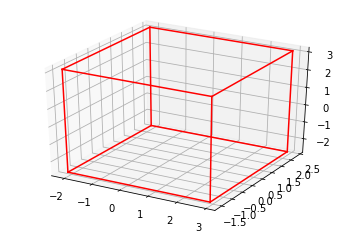

In [14]:
def edge_plot(in_edges, show, colour='red', ax=None):
  fig = plt.figure()#figsize=((432,288)))
  if ax is None:
    ax = plt.axes(projection="3d")

  for i in range(in_edges[0]['year'].shape[0]):
    yline = [val for pair in zip(in_edges[0]['year'][i:i+1], in_edges[1]['year'][i:i+1]) for val in pair]
    xline = [val for pair in zip(in_edges[0]['MaximumtemperatureDegreeC'][i:i+1], in_edges[1]['MaximumtemperatureDegreeC'][i:i+1]) for val in pair]
    zline = [val for pair in zip(in_edges[0]['MinimumtemperatureDegreeC'][i:i+1], in_edges[1]['MinimumtemperatureDegreeC'][i:i+1]) for val in pair]
    ax.plot3D(xline, yline, zline, colour)

  if show:
    plt.show()
  return(ax)

ax = edge_plot(edges,False)

*fiona_Initialise* creates the starting FIONA Region. Each FIONA Region is a list of four elements:
 - The weights (coefficients) of the linear model. It is initalised with an identity matrix to start the Identity Scoring.
 - The biases (intercept) of the linear model. It is initialised with an array of zeroes the length of the continuous variables because Identity Scoring assumes that each input channel has its own bias.
 - The edges of the region
 - The categorical values of the region. Each combination of categorical values has their own unique embedding matrix, which almost certainly results in a unique model at the end. These values are populated when the embedding matrix is processed.

The initialised FIONA Region is returned as a list of a single region because it is likely there will be several regions once the ReLUs are applied.

In [15]:
def fiona_Initialise(learn):
  cont_len = learn.data.train_ds[0][0].data[1].shape[0]
  weight = np.eye(cont_len)
  bias = np.zeros(cont_len)
  cats = pd.DataFrame(data=[], columns=learn.data.train_ds.cont_names)

  edges = pd.DataFrame(data = np.expand_dims(np.zeros(len(learn.data.train_ds.cont_names)), 0), 
                      columns = learn.data.train_ds.cont_names) 
  edges = [edges.copy(), edges.copy()]
  edges = fiona_Initialise_Edges(learn, edges, 0)

  return([[weight, bias, edges, cats]])

fiona_list = fiona_Initialise(learn)

*fiona_BatchNorm1d* runs a list comprehension for each region in the supplied FIONA list.

*fiona_BatchNorm1d_region* applies the same maths as a standard BatchNorm1d layer, except the weight and bias calculations are split

In [16]:
def fiona_BatchNorm1d_region(ml, fiona_region):
  in_weight = fiona_region[0]
  in_bias = fiona_region[1]
  in_edges = fiona_region[2]
  in_cats = fiona_region[3]

  bn_weight = ml.weight.detach().numpy()
  bn_bias = ml.bias.detach().numpy()
  bn_running_var = ml.running_var.detach().numpy()
  bn_running_mean = ml.running_mean.detach().numpy()
  bn_eps = ml.eps

  out_weight = ((in_weight)                 / np.sqrt(bn_running_var + bn_eps)) * bn_weight
  out_bias =   ((in_bias - bn_running_mean) / np.sqrt(bn_running_var + bn_eps)) * bn_weight + bn_bias

  return out_weight, out_bias, in_edges, in_cats

def fiona_BatchNorm1d(ml, in_fiona_list):
  return [fiona_BatchNorm1d_region(ml, region) for region in in_fiona_list]

fiona_list = fiona_BatchNorm1d(learn.model.bn_cont, fiona_list)
[weight, bias, edges, cats] = fiona_list[0]
weight

array([[0.904585, 0.      , 0.      ],
       [0.      , 1.008343, 0.      ],
       [0.      , 0.      , 0.851845]])

Axis 1 of the weights is the layer, and summing on it results in weights that allow a direct comparison between the calculated output with the actual layer output. 

The first three values from the input need to be dropped because they represent the categorical values, which haven't been brought into the model yet.

In [17]:
weight.sum(axis=1) * input[3:, 0] + bias

array([1.606386, 0.376331, 0.131876])

The predicted output of the layer is an exact match with the original model.

In [18]:
get_out(df.iloc[172319], learn.model, learn.model.bn_cont)

array([1.606386, 0.376331, 0.131876], dtype=float32)

*fiona_Embedding_weight* extracts the weights from the embedding matrix for a given set of categorical values and returns them in a 2-d array. The return array preserves the link between each categorical variable and the output by having the results split by row. This approach is conceptually similar to the use of an identity matrix for continuous variables, but doesn't meet the definition of an identity matrix.

In [19]:
def fiona_Embedding_weight(learn, cat_filter):
  cat_len = learn.data.train_ds[0][0].data[0].shape[0]
  cat_weight_len = 0
  for i in range(cat_len):
    cat_weight_len = cat_weight_len + learn.model.embeds[i].weight.shape[1]
  cat_weight = np.zeros((cat_len, cat_weight_len))

  cat_weight_len = 0
  for i in range(cat_len):
    len = learn.model.embeds[i].weight.shape[1]
    cat_weight[i:i+1, cat_weight_len:cat_weight_len+len] = learn.model.embeds[i].weight[cat_filter[i]].detach().numpy()
    cat_weight_len = cat_weight_len + len
  return(cat_weight)

cat_filter = data.one_item(raw_input)[0][0][0].detach().numpy()
cat_weight = fiona_Embedding_weight(learn, cat_filter)
cat_weight

array([[-0.558678,  0.368942, -0.240399,  0.310319, ...,  0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      , ...,  0.184675, -0.126688,  0.290476, -0.15661 ]])

The results line up with the values from the embedding.

In [20]:
cat_filter = data.one_item(raw_input)[0][0][0].detach().numpy()
learn.model.embeds[0].weight[cat_filter[0]].detach().numpy()

array([-0.558678,  0.368942, -0.240399,  0.310319, -0.320531, -0.21501 ,  0.438519, -0.315915, -0.328055,  0.625971,
       -0.228269,  0.948768, -0.221691, -0.277921], dtype=float32)

In [21]:
learn.model.embeds[2].weight[cat_filter[2]].detach().numpy()

array([ 0.00769 , -0.195868, -0.171507,  0.184675, -0.126688,  0.290476, -0.15661 ], dtype=float32)

*fiona_Embedding_merge* merges the weights from the embedding with the FIONA region

In [22]:
def fiona_Embedding_merge(learn, fiona_region, cat_values, cat_weight):
  in_weight = fiona_region[0]
  in_bias = fiona_region[1]
  in_edges = fiona_region[2]
  
  weight = np.zeros((in_weight.shape[0]+cat_weight.shape[0], in_weight.shape[1]+cat_weight.shape[1]))
  weight[0:cat_weight.shape[0], 0:cat_weight.shape[1]] = cat_weight
  weight[cat_weight.shape[0]:in_weight.shape[0]+cat_weight.shape[0], cat_weight.shape[1]:in_weight.shape[1]+cat_weight.shape[1]] = in_weight

  bias = np.zeros((in_bias.shape[0]+cat_weight.shape[1]))
  bias[cat_weight.shape[1]:cat_weight.shape[1]+in_bias.shape[0]] = in_bias

  for i in range(len(learn.data.train_ds.cat_names)):
    in_edges[0].insert(i, learn.data.train_ds.cat_names[i], 1)
    in_edges[1].insert(i, learn.data.train_ds.cat_names[i], 1)

  cats = pd.DataFrame(data=np.expand_dims(cat_values, 0), columns=learn.data.train_ds.cat_names)

  return([weight, bias, in_edges, cats])

cat_vars = list(data.train_ds.x.classes.keys())
cat_values = raw_input[cat_vars].to_numpy()
[weight, bias, edges, cats] = fiona_Embedding_merge(learn, [weight.copy(), bias.copy(), deepcopy(edges)], cat_values, cat_weight)
weight

array([[-0.558678,  0.368942, -0.240399,  0.310319, ...,  0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      , ..., -0.15661 ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      , ...,  0.      ,  0.904585,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  1.008343,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ,  0.851845]])

The categorical variables are added to the edges to make it easier to split the regions when the ReLUs are being processed.

In [23]:
edges[0]

,hour,weekday,month,year,MaximumtemperatureDegreeC,MinimumtemperatureDegreeC
0,1,1,1,-1.532967,-2.102996,-2.700646
0,1,1,1,-1.532967,2.930314,-2.700646
0,1,1,1,-1.532967,-2.102996,-2.700646
0,1,1,1,2.354905,-2.102996,-2.700646
0,1,1,1,-1.532967,-2.102996,3.128174
0,1,1,1,-1.532967,2.930314,3.128174
0,1,1,1,-1.532967,-2.102996,3.128174
0,1,1,1,2.354905,-2.102996,3.128174
0,1,1,1,-1.532967,-2.102996,-2.700646
0,1,1,1,-1.532967,2.930314,-2.700646


And the categorical values are defined.

In [24]:
cats

,hour,weekday,month
0,7.5,2,1


*fiona_Embedding* creates a cartesian product of all categories and then runs that through a list comprehension of *fiona_Embedding_update_input* to return the updated region.

The resulting FIONA List is 48 half-hour intervals x 7 days of the week x 12 months of the year = 4032. This will jump to 5096 once the 'N/A' categories are included.

In [25]:
def fiona_Embedding_update_input(learn, in_fiona_region, cat_point):
  df = learn.data.train_ds.x.inner_df.iloc[0].copy()                                      #Pull a record from the dataset, it's not important what it is
  df[list(learn.data.train_ds.x.classes.keys())] = cat_point                              #Update the categorical values with the combination we're interested in
  cat_filter = learn.data.one_item(df)[0][0][0].detach().numpy()                          #Process the updated value through one_item
  cat_weight = fiona_Embedding_weight(learn, cat_filter)                                  #Pull the category weights
  out_fiona_region = fiona_Embedding_merge(learn, in_fiona_region, cat_point, cat_weight) #Merge the category weights with the rest of the region
  return out_fiona_region

def fiona_Embedding(learn, in_fiona_list):
  #TODO handle N/A category
  cat_list = [learn.data.train_ds.x.inner_df[cat].drop_duplicates().to_numpy() for cat in list(learn.data.train_ds.x.classes.keys())]
  cartesian_product = itertools.product(*cat_list)
  cat_points = np.array([*list(cartesian_product)])

  out_fiona_list = [fiona_Embedding_update_input(learn, deepcopy(in_fiona_list[0]), cat_point) for cat_point in cat_points]
  return out_fiona_list

fiona_list = fiona_Embedding(learn, fiona_list)
len(fiona_list)

4032

A filter function to find matching FIONA Regions for any given point needs to be defined now that there are multiple regions.

*fiona_Connect_Points* connects the edges that are broken when a polygon is sliced by a plane. This function only works with convex polygons, and is also used in processing ReLU because it has the same problem.

*fiona_Point_Filter_cont* is an implementation of the Point in Polygon problem that works on any number of dimensions. The polygon is recursively sliced along each dimension at the value of the point, until either the point is found to be outside the slice plane or every dimension has been tested. This solution only works with convex polygons, concave polygons cannot be created under Wagtail Lab's definition of an Ordinary Neural Network.

*fiona_Point_Filter_cat* removes non-matching category combinations.

*fiona_Point_Filter* returns any encompassing FIONA Regions for a given point. Multiple regions should only be returned when the point is exactly on each edge, which would mean that the resulting equations would be equal. 

Testing this function shows that the returning weights are the same as what was shown for single category combination we calculated earlier.

In [26]:
def fiona_Connect_Points(split_position):
  #TODO make this function work for more than three dimensions
  split_position['__index__'] = list(range(split_position.shape[0]))                                                     #define the index, which is the key for each point we're connecting
  cartesian_product = itertools.product(split_position.to_numpy(), split_position.to_numpy(), split_position.to_numpy()) #create a cartestian product of all corners
  cartesian_product = np.array([*list(cartesian_product)])
  edge_A = pd.DataFrame(data=cartesian_product[:,0,:], columns=split_position.columns)                                   #pull the corners from each triplet into three lists
  edge_B = pd.DataFrame(data=cartesian_product[:,1,:], columns=split_position.columns)
  edge_C = pd.DataFrame(data=cartesian_product[:,2,:], columns=split_position.columns)
  unique_point_filter = ((edge_A['__index__'] != edge_B['__index__'])&
                         (edge_A['__index__'] != edge_C['__index__'])&
                         (edge_B['__index__'] < edge_C['__index__']))                                                    #filter points to just the unique pairs
  edge_A = edge_A[unique_point_filter]
  edge_B = edge_B[unique_point_filter]
  edge_C = edge_C[unique_point_filter]

  edge_A['__side_c__'] = list(np.diagonal(euclidean_distances(edge_A.drop('__index__', axis=1), 
                                                              edge_B.drop('__index__', axis=1))))                        #the euclidean distance shows how far apart each pair of points is
  edge_A['__side_b__'] = list(np.diagonal(euclidean_distances(edge_A.drop(['__index__', '__side_c__'], axis=1),
                                                              edge_C.drop('__index__', axis=1))))                        #np.diagonal is used return just the values for each pair
  edge_A['__side_a__'] = list(np.diagonal(euclidean_distances(edge_B.drop('__index__', axis=1), 
                                                              edge_C.drop('__index__', axis=1))))
  
  edge_A['__ratio_a__'] = (edge_A['__side_b__'] + edge_A['__side_c__']) / edge_A['__side_a__']                           #calculate the ratio of the sides, the smaller the ratio the wider the angle
  edge_A["__rank_ratio_a__"] = edge_A.groupby("__index__")["__ratio_a__"].rank("dense")                                  #rank the distances to find the widest angle for each point
  ratio_filter = (edge_A["__rank_ratio_a__"] == 1)
  edge_A = edge_A[ratio_filter]
  edge_B = edge_B[ratio_filter]
  edge_C = edge_C[ratio_filter]

  unique_side_filter_b = (edge_A['__index__'] < edge_B['__index__'])                                                     #each line will show up twice, so the duplicates should to be removed
  unique_side_filter_c = (edge_A['__index__'] < edge_C['__index__'])
  drops=['__index__', '__side_c__', '__side_b__', '__side_a__', '__ratio_a__', '__rank_ratio_a__']                       #drop temp columns
  return([edge_A[unique_side_filter_b].append(edge_A[unique_side_filter_c]).drop(drops, axis=1),
          edge_B[unique_side_filter_b].append(edge_C[unique_side_filter_c]).drop('__index__', axis=1)])                  #return the new edges 

def fiona_Point_Filter_cont(learn, edges, point):
  if edges[0].shape[1] > len(learn.data.train_ds.cont_names):                                      #If the categorical variables haven't been removed from the edges then drop them
    edge_0 = edges[0][learn.data.train_ds.cont_names]                                              #It's a bit easier this way because the edges are dropped when no longer needed
    edge_1 = edges[1][learn.data.train_ds.cont_names]
  else:
    edge_0 = edges[0]                                                                     
    edge_1 = edges[1]

  value = point[0]                                                                                 #Take the value from the first columns of the point
  if type(point[0]) == np.ndarray:                                                                 #Under some circumstances that will be an array
    value = value[0]

  edge_filter = ((edge_0.iloc[:, 0] <= value) & (value <= edge_1.iloc[:,0]) | 
                (edge_1.iloc[:,0] <= value) & (value <= edge_0.iloc[:,0]))                         #Find the edges that pass that value for that dimension
  if len(edge_filter) == 0:                                                                        #If there are none then the point is not in the region
    return False
  if (len(edge_filter) > 0)&(edge_0.shape[1] == 1):                                                #If there is at least one and it is the last column to consider
    return True                                                                                         
  edge_0 = edge_0[edge_filter]                                                                     #Filter the edges to those that overlap
  edge_1 = edge_1[edge_filter]

  x = edge_0-edge_1
  a = (value - edge_1.iloc[:,0]) / x.iloc[:,0]
  split_position = edge_1.iloc[:,1:] + x.iloc[:,1:]*np.expand_dims(a, 1)                           #Find the point on the edges where the intersect the point at that dimension
  if split_position.shape[0] > 2:                                                                  #If the edges have more than two dimensions then it's a plane
    connections = fiona_Connect_Points(split_position)                                             #And we need to recurse
    return fiona_Point_Filter_cont(learn, connections, point[1:])
  if split_position.shape[0] == 2:                                                                 #If the edges have exactly two dimensions then it's a line
    return ((split_position[0:1].iloc[0][0] <= value) & (value <= split_position[1:2].iloc[0][0])|
            (split_position[1:2].iloc[0][0] <= value) & (value <= split_position[0:1].iloc[0][0])) #Return whether or not the point is on the line
  if split_position.shape[0] == 1:                                                                 #If the edges have only a single dimension then it's a point
    return split_position[0:1] == value                                                            #Return whether the point is the value
  return False

def fiona_Point_Filter_cat(learn, in_cats, point):
  cats = in_cats.to_numpy()
  point_cats = point[learn.data.train_ds.cat_names].to_numpy()
  return (point_cats == cats).all(1)[0]

def fiona_Point_Filter(learn, in_point, in_fiona_list):
  matches = [fiona_Point_Filter_cat(learn, fiona_region[3], in_point) for fiona_region in in_fiona_list]  #Filter the categories
  out_fiona_list = list(compress(in_fiona_list, matches))
  point = data.one_item(in_point)[0][0][0].detach().numpy()                                               #Convert category values in the point to a value of one
  point[:] = 1
  point = np.append(point, data.one_item(in_point)[0][1][0].detach().numpy())
  matches = [fiona_Point_Filter_cont(learn, fiona_region[2], point) for fiona_region in out_fiona_list]   #Filter the continuous variables
  out_fiona_list = list(compress(out_fiona_list, matches))
  return out_fiona_list

fiona_list_filtered = fiona_Point_Filter(learn, raw_input, fiona_list)
[weight, bias, edges, cats] = fiona_list_filtered[0]
weight

array([[-0.558678,  0.368942, -0.240399,  0.310319, ...,  0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      , ..., -0.15661 ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      , ...,  0.      ,  0.904585,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  1.008343,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ,  0.851845]])

*fiona_Linear_region* applies the weights and biases of a Linear layer to a given FIONA Region.

*fiona_Linear* applies *fiona_Linear_region* to a FIONA List via a list comprehension.

The differences between the test results below are negative values being replaced with zero due to the subsequent in-place ReLU layer.

In [27]:
def fiona_Linear_region(layer, fiona_region):
  in_weight = fiona_region[0]
  in_bias = fiona_region[1]
  in_edges = fiona_region[2]
  in_cats = fiona_region[3]

  weight = np.expand_dims(layer.weight.detach().numpy(), 0) * np.expand_dims(in_weight, 1)
  weight = np.sum(weight, axis=2)
  bias = np.sum(layer.weight.detach().numpy() * in_bias, 1) + layer.bias.detach().numpy()
  return([weight, bias, in_edges, in_cats])

def fiona_Linear(layer, in_fiona_list):
  out_fiona_list = [fiona_Linear_region(layer, fiona_region) for fiona_region in in_fiona_list]
  return out_fiona_list

fiona_list = fiona_Linear(learn.model.layers[0], fiona_list)
fiona_list_filtered = fiona_Point_Filter(learn, raw_input, fiona_list)
[weight, bias, edges, cats] = fiona_list_filtered[0]
np.sum(weight * input, 0) + bias

array([ 0.101665,  2.643488,  0.041645,  3.058939,  0.576065,  2.933302, -1.566371,  3.15702 ,  1.061421, -1.701185])

In [28]:
get_out(df.iloc[172319], learn.model, learn.model.layers[0])

array([0.101665, 2.643488, 0.041645, 3.058939, 0.576065, 2.933301, 0.      , 3.15702 , 1.061421, 0.      ],
      dtype=float32)

*fiona_ReLU_split_position* finds the points on a FIONA Region where the calculation of a given channel would be zero, and hence represent the boundary at which the region should be split to zero the weights and biases.

In [29]:
def fiona_ReLU_split_position(fiona_region, in_channel):
  in_weight = fiona_region[0]
  in_bias = fiona_region[1]
  in_edges = fiona_region[2]
  in_cats = fiona_region[3]

  coef = in_weight[:,in_channel]                                          #Find the weight of the channel
  gradient = (in_edges[0] - in_edges[1])                                  #Gradient of the line
  p_numerator = -np.sum(in_edges[0] * coef, axis=1) - in_bias[in_channel] #Value at point zero
  p_denominator = np.sum(gradient * coef, axis=1)                         #Rate that the result changes on the line
  p = p_numerator / p_denominator                                         #Amount of movement along the line to equal zero
  split_position = in_edges[0] + np.expand_dims(p, 1)*gradient.to_numpy() #Add movement to point zero
  return(split_position)

channel = 6
split_position = fiona_ReLU_split_position(fiona_list_filtered[0], channel)
split_position

,hour,weekday,month,year,MaximumtemperatureDegreeC,MinimumtemperatureDegreeC
0,1.0,1.0,1.0,76.079181,-2.102996,-2.700646
0,1.0,1.0,1.0,-5.452361,2.930314,-2.700646
0,1.0,1.0,1.0,-1.532967,2.688352,-2.700646
0,1.0,1.0,1.0,2.354905,2.448337,-2.700646
0,1.0,1.0,1.0,72.203560,-2.102996,3.128174
0,1.0,1.0,1.0,-9.327983,2.930314,3.128174
0,1.0,1.0,1.0,-1.532967,2.449093,3.128174
0,1.0,1.0,1.0,2.354905,2.209077,3.128174
0,1.0,1.0,1.0,-1.532967,-2.102996,114.025745
0,1.0,1.0,1.0,-1.532967,2.930314,-8.595300


The split points sometimes aren't exactly zero due to a lack of precision.

In [30]:
np.sum(split_position[learn.data.train_ds.cont_names].to_numpy() * weight[len(learn.data.train_ds.cat_names):,channel], axis=1) + \
np.sum(weight[:len(learn.data.train_ds.cat_names),channel]) + \
bias[channel]

array([ 4.440892e-16,  0.000000e+00,  4.440892e-16,  4.440892e-16,  8.881784e-16, -4.440892e-16,  8.881784e-16,
       -4.440892e-16, -4.440892e-16,  4.440892e-16, -4.440892e-16,  0.000000e+00])

*fiona_ReLU_split* takes a FIONA Region, a channel, and a side (1=positive, 0=negative) and returns the polygon which is on that side of the split. If the region is entirely positive or negative for that channel then it won't be split and the missing side will be returned as None.

The following cells test the region calculated on a variety of different channels and the input value is represented as a black dot. Unfortunately a lack of depth perception can make these 3d plots difficult to interpret. Methods of visualising FIONA Regions with more than two dimensions are continuing to be investigated.

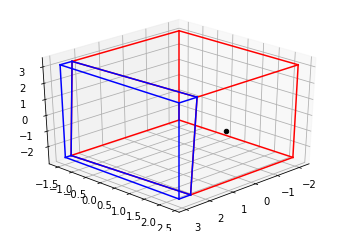

<Figure size 432x288 with 0 Axes>

In [31]:
def fiona_ReLU_split(in_fiona_region, in_channel, in_side):
  in_weight = in_fiona_region[0]
  in_bias = in_fiona_region[1]
  in_edges = in_fiona_region[2]
  in_cats = in_fiona_region[3]

  out_edges = deepcopy(in_edges)
  split_position = fiona_ReLU_split_position(in_fiona_region, in_channel)                                                                    #Find the split points
  edge_test_0 = np.expand_dims((np.sum(np.expand_dims(in_weight[:,in_channel], 0) * out_edges[0], axis=1) + in_bias[in_channel] > 0) * 1, 1) #Test if the points on each edge are positive or not
  edge_test_1 = np.expand_dims((np.sum(np.expand_dims(in_weight[:,in_channel], 0) * out_edges[1], axis=1) + in_bias[in_channel] > 0) * 1, 1) #Times one to convert to integer because bools can't be added
  out_edges[0][:] = (out_edges[0].to_numpy() * (edge_test_0 == in_side)*1) + (split_position.to_numpy() * (edge_test_0 != in_side)*1)        #Take the original edge point if it matches the requested side
  out_edges[1][:] = (out_edges[1].to_numpy() * (edge_test_1 == in_side)*1) + (split_position.to_numpy() * (edge_test_1 != in_side)*1)        #Take the split position if it doesn't

  if in_side == 0: side_filter = ((edge_test_0 + edge_test_1) < 2)[:,0]                                                                      #If we're after the zero side then we need to drop edges where 
  else: side_filter = ((edge_test_0 + edge_test_1) > 0)[:,0]                                                                                 #Both ends are positive, and vice versa
  out_edges[0] = out_edges[0][side_filter]
  out_edges[1] = out_edges[1][side_filter]

  split_position = split_position[((edge_test_0 + edge_test_1) == 1)[:,0]]                                                                   #Filter the split position to the ones that have been selected
  if(split_position.shape[0] > 0):                                                                                                           #If there's any splits that need to be connected
    [edge_out_0, edge_out_1] = fiona_Connect_Points(split_position)                                                                          #Connect the split points
    out_edges[0] = out_edges[0].append(edge_out_0)                                                                                           #Add the new edges to the shape
    out_edges[1] = out_edges[1].append(edge_out_1)
  return([in_weight, in_bias, out_edges, in_cats])

side = 0
fiona_list_filtered_split_0 = fiona_ReLU_split(fiona_list_filtered[0], channel, side)
side = 1
fiona_list_filtered_split_1 = fiona_ReLU_split(fiona_list_filtered[0], channel, side)
ax = edge_plot(fiona_list_filtered_split_0[2],False)
edge_plot(fiona_list_filtered_split_1[2],False,'blue',ax)

ax.scatter3D(input[4], input[3], input[5], color='black');
ax.view_init(30, 45)
plt.draw()

In [32]:
print(fiona_Point_Filter_cont(learn, edges, input))
print(fiona_Point_Filter_cont(learn, fiona_list_filtered_split_0[2], input))
print(fiona_Point_Filter_cont(learn, fiona_list_filtered_split_1[2], input))

True
True
False


True


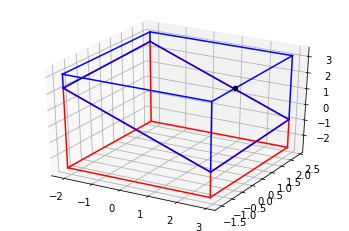

<Figure size 432x288 with 0 Axes>

In [33]:
fiona_list_filtered_split_test = fiona_ReLU_split(fiona_list_filtered[0], 0, 1)
fiona_list_filtered_split_other = fiona_ReLU_split(fiona_list_filtered[0], 0, 0)
ax = edge_plot(fiona_list_filtered_split_other[2],False)
edge_plot(fiona_list_filtered_split_test[2],False,'blue',ax)
ax.scatter3D(input[4], input[3], input[5], color='black');
plt.draw()
print(fiona_Point_Filter_cont(learn, fiona_list_filtered_split_test[2], input))

True
False


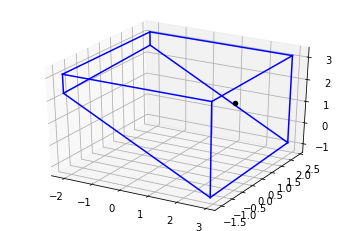

<Figure size 432x288 with 0 Axes>

In [34]:
fiona_list_filtered_split_other = fiona_ReLU_split(fiona_list_filtered_split_test, 1, 0)
fiona_list_filtered_split_test = fiona_ReLU_split(fiona_list_filtered_split_test, 1, 1)
ax = edge_plot(fiona_list_filtered_split_other[2],False)
edge_plot(fiona_list_filtered_split_test[2],False,'blue',ax)
ax.scatter3D(input[4], input[3], input[5], color='black');
plt.draw()
print(fiona_Point_Filter_cont(learn, fiona_list_filtered_split_test[2], input))
print(fiona_Point_Filter_cont(learn, fiona_list_filtered_split_other[2], input))

True
False


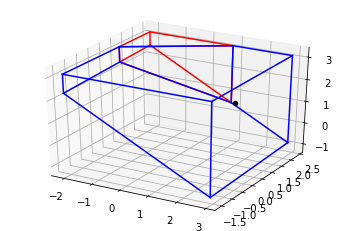

<Figure size 432x288 with 0 Axes>

In [35]:
fiona_list_filtered_split_other = fiona_ReLU_split(fiona_list_filtered_split_test, 2, 0)
fiona_list_filtered_split_test = fiona_ReLU_split(fiona_list_filtered_split_test, 2, 1)
ax = edge_plot(fiona_list_filtered_split_other[2],False)
edge_plot(fiona_list_filtered_split_test[2],False,'blue',ax)
ax.scatter3D(input[4], input[3], input[5], color='black');
plt.draw()
print(fiona_Point_Filter_cont(learn, fiona_list_filtered_split_test[2], input))
print(fiona_Point_Filter_cont(learn, fiona_list_filtered_split_other[2], input))

*fiona_ReLU_region* recursively processes ReLU for all channels of a given FIONA Region, returning a FIONA List.

The test region gets split into 19 separate regions, that means that within the area of interest, for this combination of categories, the Neural Network is actually 19 independent linear models.

In [36]:
%%time
def fiona_ReLU_region(fiona_region, channel=0):
  fiona_region_positive = deepcopy(fiona_region)                                  #Process the positive side
  fiona_region_positive = fiona_ReLU_split(fiona_region_positive, channel, 1)
  positive_shape = fiona_region_positive[2][0].shape[0]
  if positive_shape > 0:                                                          #If the positive side has at least some volume 
    if channel+1 < fiona_region[0].shape[1]:                                      #and there are more channels to process
      fiona_region_positive = fiona_ReLU_region(fiona_region_positive, channel+1) #Recurse
    if channel+1 == fiona_region[0].shape[1]:                                     #If there are no more channels to process
      fiona_region_positive = [fiona_region_positive]                             #Put the region in a list

  fiona_region_zero = deepcopy(fiona_region)                                      #Process the negative side
  fiona_region_zero = fiona_ReLU_split(fiona_region_zero, channel, 0)
  zero_shape = fiona_region_zero[2][0].shape[0]
  if zero_shape > 0:                                                              #If the negative side has some volumne
    fiona_region_zero[0][:, channel] = 0                                          #Set the weights for this channel to zero
    fiona_region_zero[1][channel] = 0                                             #Set the biases for this channel to zero
    if channel+1 < fiona_region[0].shape[1]:                                      #If there are more channels to process
      fiona_region_zero = fiona_ReLU_region(fiona_region_zero, channel+1)         #Recurse
    if channel+1 == fiona_region[0].shape[1]:                                     #If there are no more channels to process
      fiona_region_zero = [fiona_region_zero]                                     #Put the region in a list

  if zero_shape == 0:                                                             #If there was no volume on the negative side
    return fiona_region_positive                                                  #Return the positive side
  if positive_shape == 0:                                                         #If there was no volume on the positive side
    return fiona_region_zero                                                      #Return the negative side
  return fiona_region_positive + fiona_region_zero                                #Otherwise concatenate the lists and return

fiona_list_filtered_split = fiona_ReLU_region(fiona_list_filtered[0])
print(len(fiona_list_filtered_split))

19
CPU times: user 1.81 s, sys: 2.83 ms, total: 1.82 s
Wall time: 1.82 s


*fiona_ReLU* runs a list comprehension over all regions in the FIONA List.

The ten regions processed below became 200 regions after the ReLU, meaning that the full model is probably around a million linear models.

It would take about an hour and a half to process the whole network on Colab. Improving this performance is being investigated.

In [37]:
%%time
def fiona_ReLU(in_fiona_list):
  fiona_list_lc = [fiona_ReLU_region(fiona_region) for fiona_region in in_fiona_list]
  return list(itertools.chain(*fiona_list_lc))

fiona_list_ReLU = deepcopy(fiona_list[0:10])                                          #limited to ten here for speed of the walkthrough
print(len(fiona_list_ReLU))
fiona_list_ReLU = fiona_ReLU(fiona_list_ReLU)
print(len(fiona_list_ReLU))

10
200
CPU times: user 15.6 s, sys: 7.84 ms, total: 15.7 s
Wall time: 15.7 s


Testing the sample point shows that the linear model for the point of interest is an unusually shaped polygon.

True


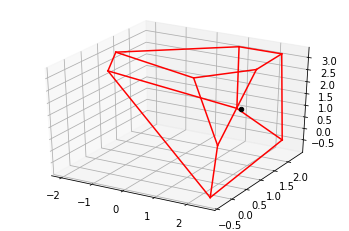

In [38]:
fiona_list_filtered = fiona_Point_Filter(learn, raw_input, fiona_list_filtered_split)
ax = edge_plot(fiona_list_filtered[0][2],False)
ax.scatter3D(input[4], input[3], input[5], color='black');
plt.draw()
print(fiona_Point_Filter_cont(learn, fiona_list_filtered[0][2], input))

And testing the weights and biases of the model shows that the behaviour is correct.

In [39]:
[weight, bias, edges, cats] = fiona_list_filtered[0]
np.sum(weight * input, 0) + bias

array([0.101665, 2.643488, 0.041645, 3.058939, 0.576065, 2.933302, 0.      , 3.15702 , 1.061421, 0.      ])

In [40]:
get_out(df.iloc[172319], learn.model, learn.model.layers[0])

array([0.101665, 2.643488, 0.041645, 3.058939, 0.576065, 2.933301, 0.      , 3.15702 , 1.061421, 0.      ],
      dtype=float32)

The last two layers of the model are applied to round out the walkthrough.

In [41]:
fiona_list_filtered = fiona_Point_Filter(learn, raw_input, fiona_list_filtered_split)
[weight, bias, edges, cats] = fiona_list_filtered[0]
np.sum(weight * np.expand_dims(input, 0), axis=1) + bias

array([[0.101665, 2.643488, 0.041645, 3.058939, 0.576065, 2.933302, 0.      , 3.15702 , 1.061421, 0.      ]])

In [42]:
get_out(df.iloc[172319], learn.model, learn.model.layers[1])

array([0.101665, 2.643488, 0.041645, 3.058939, 0.576065, 2.933301, 0.      , 3.15702 , 1.061421, 0.      ],
      dtype=float32)

In [43]:
fiona_list_filtered = fiona_BatchNorm1d(learn.model.layers[2], fiona_list_filtered)
[weight, bias, edges, cats] = fiona_list_filtered[0]
np.sum(weight * np.expand_dims(input, 0), axis=1) + bias

array([[  6.627854,  18.234922, -13.902263,   7.270729,   7.144721, -12.45024 ,   8.100237, -11.825362, -15.563116,
          7.566479]])

In [44]:
get_out(df.iloc[172319], learn.model, learn.model.layers[2])

array([  6.627854,  18.234922, -13.902264,   7.270728,   7.144721, -12.45024 ,   8.100237, -11.825363, -15.563117,
         7.566479], dtype=float32)

The final result of FIONA matches to the fourth decimal place, the rounding error is being investigated.

In [45]:
fiona_list_filtered = fiona_Linear(learn.model.layers[3], fiona_list_filtered)
[weight, bias, edges, cats] = fiona_list_filtered[0]
np.sum(weight * np.expand_dims(input, 0), axis=1) + bias

array([[969.940533]])

In [46]:
get_out(df.iloc[172319], learn.model, learn.model.layers[3])

array([969.94055], dtype=float32)

FIONA's real value becomes clear - it is now possible to inspect the intercept and coefficients of the linear model. Interestingly, for this particular record the majority of the result comes from the model's biases.

In [47]:
bias

array([966.449429])

In [48]:
weight

array([[ 28.619897],
       [ 58.54722 ],
       [  3.860721],
       [-54.518293],
       [ -0.452366],
       [ 81.109414]])

In [49]:
input

array([[1.      ],
       [1.      ],
       [1.      ],
       [2.354905],
       [0.989571],
       [0.509144]])